# 🔥 Transfer Learning с ResNet-18
## Блок 4: Классификация животных

На этом практическом занятии мы:
- Загрузим предобученную модель ResNet-18
- Заменим последний слой для нашей задачи
- Обучим модель распознавать 10 классов животных
- Визуализируем результаты

## 📦 Установка и импорт библиотек

In [ ]:
# Запустите эту ячейку если чего-то не хватает
# !pip install torch torchvision matplotlib tqdm

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os

# Для отображения графиков прямо в ноутбуке
#%matplotlib inline

ModuleNotFoundError: No module named 'tqdm'

## 🖥️ Проверка устройства (CPU/GPU)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Используем устройство: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")

✅ Используем устройство: cpu


## 🗂️ Загрузка и подготовка датасета
Используем **Oxford-IIIT Pet Dataset** (кошки и собаки). В первый раз скачается ~800MB. Подробнее о датасете здесь:  

https://www.robots.ox.ac.uk/\~vgg/data/pets/

In [4]:
# Трансформации для обучения (с аугментацией)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Трансформации для валидации (без аугментации)
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Загрузка данных
print("📥 Загружаем датасет...")
full_train_dataset = datasets.OxfordIIITPet(
    root='./data',
    split='trainval',
    download=True,
    transform=train_transform
)

full_test_dataset = datasets.OxfordIIITPet(
    root='./data',
    split='test',
    download=True,
    transform=val_transform
)

📥 Загружаем датасет...


100%|███████████████████████████████████████████████████████████████████████████████| 792M/792M [05:39<00:00, 2.33MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 19.2M/19.2M [00:08<00:00, 2.14MB/s]


### 🔍 Выбираем только 10 классов для быстрого обучения

In [7]:
full_train_dataset.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

In [5]:
# Выбираем первые 10 классов (можно изменить)
selected_classes = list(range(10))

# Фильтруем индексы
train_indices = [i for i, (_, label) in enumerate(full_train_dataset) if label in selected_classes]
test_indices = [i for i, (_, label) in enumerate(full_test_dataset) if label in selected_classes]

train_dataset = Subset(full_train_dataset, train_indices)
test_dataset = Subset(full_test_dataset, test_indices)

# Создаем загрузчики данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"📊 Обучающая выборка: {len(train_dataset)} изображений")
print(f"📊 Валидационная выборка: {len(test_dataset)} изображений")
print(f"🎯 Количество классов: {len(selected_classes)}")

# Сохраняем названия классов
class_names = full_train_dataset.classes
print(f"\n🏷️ Классы: {[class_names[i] for i in selected_classes]}")

📊 Обучающая выборка: 996 изображений
📊 Валидационная выборка: 985 изображений
🎯 Количество классов: 10

🏷️ Классы: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair']


## 🖼️ Визуализация примеров из датасета

🖼️ Примеры из датасета:


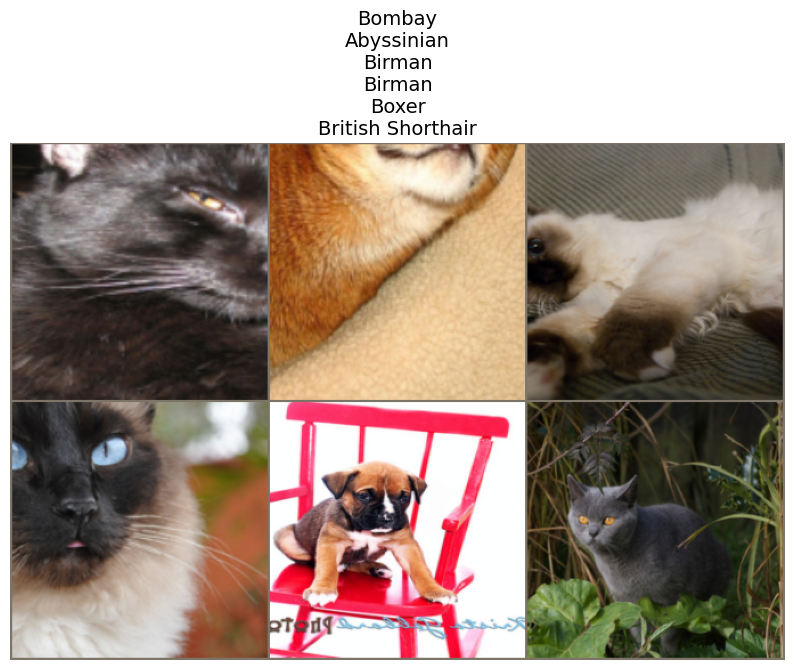

In [8]:
def imshow_tensor(tensor, title="", figsize=(10, 8)):
    """Показать изображение из тензора"""
    inp = tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

# Показываем 6 случайных изображений
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("🖼️ Примеры из датасета:")
grid = utils.make_grid(images[:6], nrow=3)
grid_labels = '\n'.join([class_names[labels[i]] for i in range(6)])
imshow_tensor(grid, title=grid_labels)

## 🏗️ Загрузка предобученной ResNet-18

In [9]:
print("⬇️ Загружаем предобученную ResNet-18...")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
print("✅ Модель загружена!")

print("\n📐 Архитектура модели:")
print(model)

⬇️ Загружаем предобученную ResNet-18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Iakov/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:05<00:00, 8.53MB/s]


✅ Модель загружена!

📐 Архитектура модели:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

## ❄️ Замораживание слоев (Freeze)
Отключаем градиенты для всех слоев, кроме последнего

In [10]:
# Замораживаем все параметры
for param in model.parameters():
    param.requires_grad = False

# Проверяем, сколько параметров будем обучать
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"🧊 Заморожено: {total_params - trainable_params:,} параметров")
print(f"🔥 Обучаем: {trainable_params:,} параметров")
print(f"📊 Процент обучаемых: {100 * trainable_params / total_params:.2f}%")

🧊 Заморожено: 11,689,512 параметров
🔥 Обучаем: 0 параметров
📊 Процент обучаемых: 0.00%


## 🔧 Замена последнего слоя (Fine-tuning)

In [11]:
num_features = model.fc.in_features
print(f"📐 Размерность входа в последний слой: {num_features}")

model.fc = nn.Linear(num_features, len(selected_classes))
print(f"✅ Новый последний слой: {model.fc}")

# Переносим модель на устройство
model = model.to(device)
print(f"📍 Модель на устройстве: {device}")

📐 Размерность входа в последний слой: 512
✅ Новый последний слой: Linear(in_features=512, out_features=10, bias=True)
📍 Модель на устройстве: cpu


## ⚙️ Настройка обучения

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

print("⚙️ Параметры для обучения:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  🔥 {name}: {param.numel():,} параметров")

⚙️ Параметры для обучения:
  🔥 fc.weight: 5,120 параметров
  🔥 fc.bias: 10 параметров


## 🏃 Цикл обучения (Training Loop)

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5):
    """Функция обучения с прогресс-баром"""
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"🎯 Эпоха {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        
        # === 1. Обучение ===
        model.train()
        running_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc="📚 Обучение", leave=False)
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"📉 Средний loss: {epoch_loss:.4f}")
        
        # === 2. Валидация ===
        model.eval()
        correct = 0
        total = 0
        
        val_pbar = tqdm(val_loader, desc="🔍 Валидация", leave=False)
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                accuracy = 100 * correct / total
                val_pbar.set_postfix({'acc': f'{accuracy:.2f}%'})
        
        val_accuracies.append(accuracy)
        print(f"✅ Точность на валидации: {accuracy:.2f}%")
        
        # === 3. Scheduler step ===
        scheduler.step()
    
    return train_losses, val_accuracies

# Запускаем обучение (5 эпох достаточно для примера)
train_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5
)


🎯 Эпоха 1/5


📚 Обучение:   0%|          | 0/32 [00:00<?, ?it/s]

📉 Средний loss: 1.7780


🔍 Валидация:   0%|          | 0/31 [00:00<?, ?it/s]

✅ Точность на валидации: 78.88%

🎯 Эпоха 2/5


📚 Обучение:   0%|          | 0/32 [00:00<?, ?it/s]

📉 Средний loss: 1.0153


🔍 Валидация:   0%|          | 0/31 [00:00<?, ?it/s]

✅ Точность на валидации: 87.31%

🎯 Эпоха 3/5


📚 Обучение:   0%|          | 0/32 [00:00<?, ?it/s]

📉 Средний loss: 0.7800


🔍 Валидация:   0%|          | 0/31 [00:00<?, ?it/s]

✅ Точность на валидации: 85.58%

🎯 Эпоха 4/5


📚 Обучение:   0%|          | 0/32 [00:00<?, ?it/s]

📉 Средний loss: 0.6674


🔍 Валидация:   0%|          | 0/31 [00:00<?, ?it/s]

✅ Точность на валидации: 88.22%

🎯 Эпоха 5/5


📚 Обучение:   0%|          | 0/32 [00:00<?, ?it/s]

📉 Средний loss: 0.6237


🔍 Валидация:   0%|          | 0/31 [00:00<?, ?it/s]

✅ Точность на валидации: 88.63%


## 📈 Визуализация обучения

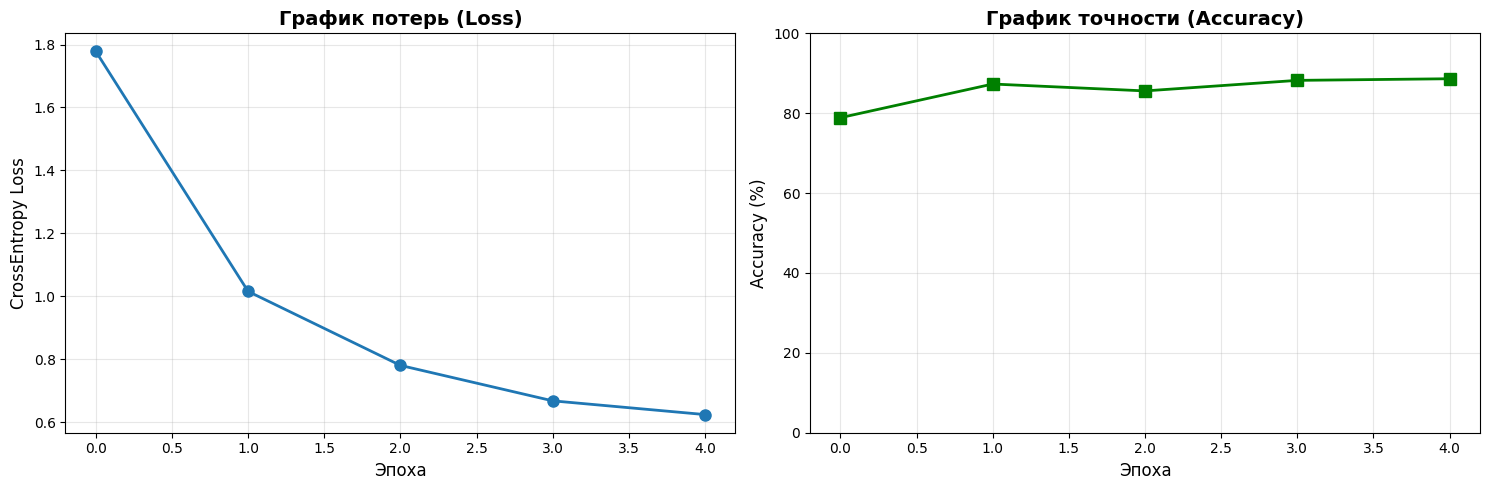

In [14]:
plt.figure(figsize=(15, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', linewidth=2, markersize=8)
plt.title('График потерь (Loss)', fontsize=14, fontweight='bold')
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('CrossEntropy Loss', fontsize=12)
plt.grid(True, alpha=0.3)

# График точности
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, marker='s', linewidth=2, markersize=8, color='green')
plt.title('График точности (Accuracy)', fontsize=14, fontweight='bold')
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🔍 Тестирование модели на случайных изображениях

🎨 Визуализация предсказаний модели:


C:\Users\Iakov\AppData\Local\Temp\ipykernel_17424\4200277736.py:36: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Iakov\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


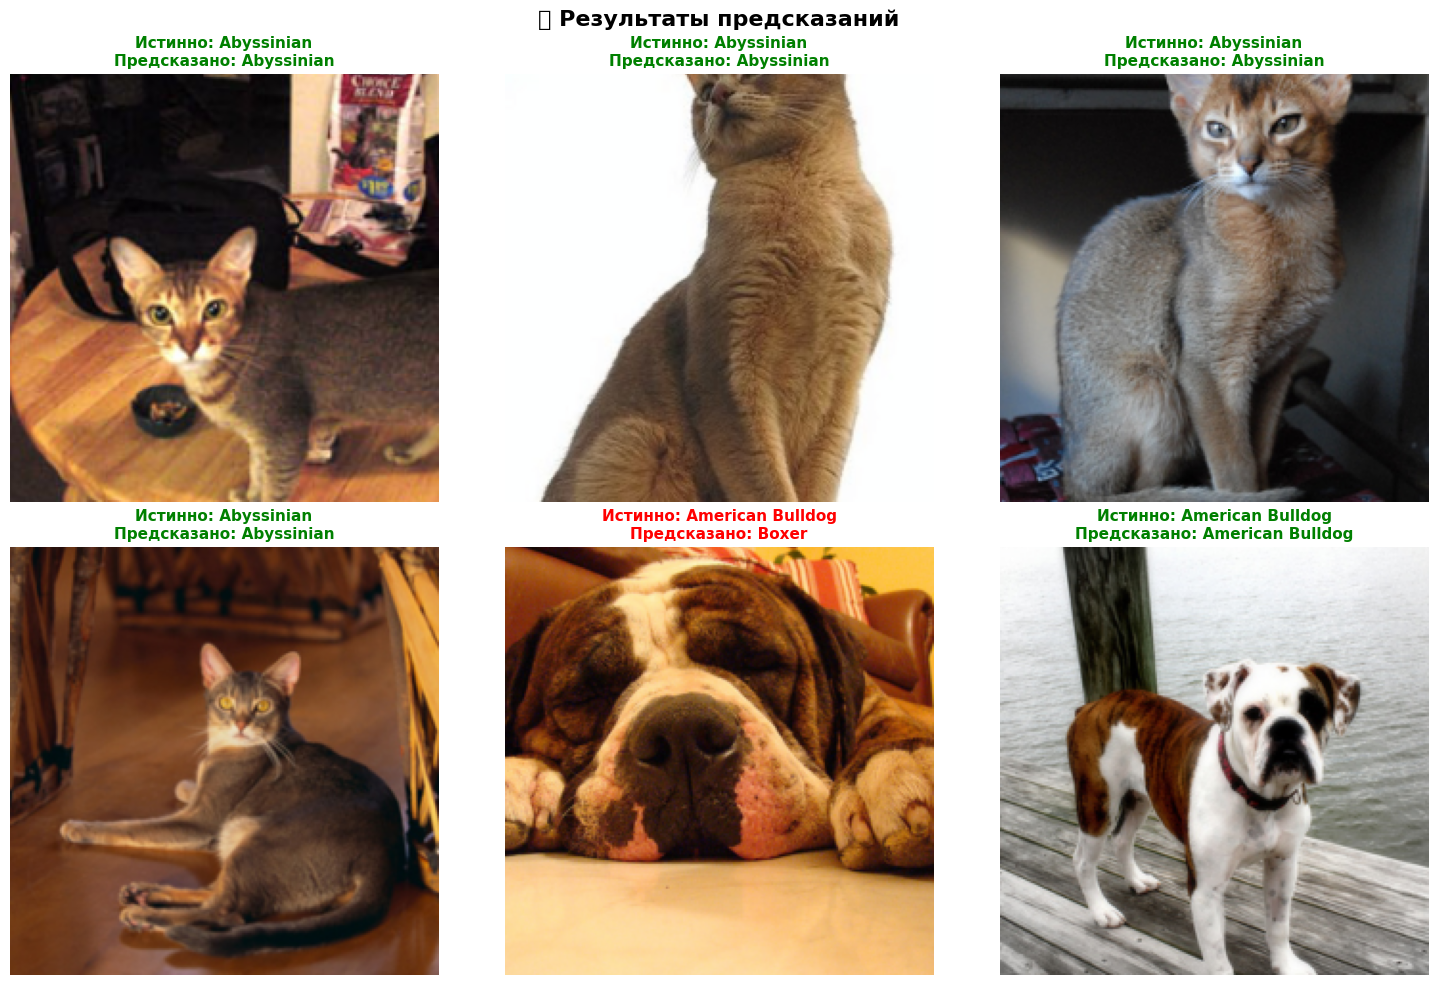

In [15]:
def visualize_predictions(model, val_loader, class_names, num_images=6):
    """Визуализация предсказаний модели"""
    model.eval()
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            if i >= num_images:
                break
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Визуализация первого изображения в батче
            image = images[0].cpu()
            true_label = class_names[labels[0]]
            pred_label = class_names[preds[0]]
            
            # Денормализация
            inp = image.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            
            axes[i].imshow(inp)
            
            # Цвет заголовка: зеленый если правильно, красный если ошибка
            color = 'green' if true_label == pred_label else 'red'
            title = f"Истинно: {true_label}\nПредсказано: {pred_label}"
            axes[i].set_title(title, fontsize=11, color=color, fontweight='bold')
            axes[i].axis('off')
    
    plt.suptitle('🔍 Результаты предсказаний', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("🎨 Визуализация предсказаний модели:")
visualize_predictions(model, val_loader, class_names)

## 💾 Сохранение обученной модели

In [16]:
# Сохраняем только веса модели
model_path = 'resnet18_pets_transfer.pth'
torch.save(model.state_dict(), model_path)
print(f"💾 Модель сохранена в файл: {model_path}")

# Сохраняем всю модель (архитектура + веса)
torch.save(model, 'resnet18_pets_full_model.pth')
print("💾 Сохранена полная модель (архитектура + веса)")

💾 Модель сохранена в файл: resnet18_pets_transfer.pth
💾 Сохранена полная модель (архитектура + веса)


## 🚀 Предсказание на своем изображении

In [17]:
from PIL import Image

def predict_single_image(image_path, model_path='resnet18_pets_transfer.pth'):
    """
    Функция для предсказания на одном изображении
    """
    # Загружаем модель
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, len(selected_classes))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    # Загружаем и преобразуем изображение
    image = Image.open(image_path).convert('RGB')
    
    # Сохраняем оригинал для показа
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title('🖼️ Ваше изображение', fontsize=14, fontweight='bold')
    plt.show()
    
    # Преобразуем для модели
    transform = val_transform
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Предсказание
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        _, pred = torch.max(output, 1)
        
        # Топ-3 предсказания
        top3_probs, top3_indices = torch.topk(probabilities, 3)
    
    # Выводим результаты
    print(f"\n🎯 Предсказание: **{class_names[pred[0]]}**")
    print(f"\n📊 Топ-3 вероятных класса:")
    for i in range(3):
        prob = top3_probs[i].item() * 100
        class_name = class_names[top3_indices[i]]
        print(f"   {i+1}. {class_name}: {prob:.2f}%")
    
    return class_names[pred[0]]

# ПРИМЕР: загрузите свое изображение в папку и укажите путь
# predict_single_image('my_pet.jpg')

C:\Users\Iakov\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


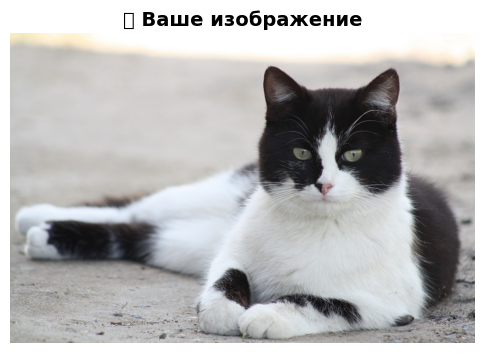


🎯 Предсказание: **British Shorthair**

📊 Топ-3 вероятных класса:
   1. British Shorthair: 24.55%
   2. Bombay: 23.69%
   3. Birman: 23.56%


'British Shorthair'

In [18]:
predict_single_image('test_cat.jpg')

## 📊 Сводка результатов

In [19]:
print("📊 СВОДКА ТРЕНИРОВКИ:")
print(f"{'='*50}")
print(f"📈 Final Accuracy: {val_accuracies[-1]:.2f}%")
print(f"📉 Final Loss: {train_losses[-1]:.4f}")
print(f"📦 Model Size: {os.path.getsize('resnet18_pets_transfer.pth') / 1024 / 1024:.2f} MB")
print(f"🔥 Trainable Parameters: {trainable_params:,}")
print(f"🎯 Classes: {len(selected_classes)}")
print(f"{'='*50}")

📊 СВОДКА ТРЕНИРОВКИ:
📈 Final Accuracy: 88.63%
📉 Final Loss: 0.6237
📦 Model Size: 42.73 MB
🔥 Trainable Parameters: 0
🎯 Classes: 10
